# Inspecting the Land ML training Zarr-Store with xarray

Now that we have saved our consolidated training database to Zarr we can start exploring it with the useful functions from `xarray`

In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


def find_nearest_idx(
    arr1: np.ndarray,
    arr2: np.ndarray,
    val1: float,
    val2: float,
) -> int:
    """Find first nearest index for two arrays and 2 values

    :param arr1: first array
    :param arr2: second array
    :param val1: value to find in first array
    :param val2: value to find in second array
    :return: index as int
    """
    return (np.abs(arr1 - val1) + np.abs(arr2 - val2)).argmin()

## Opening the dataset

We use `xarray`'s `open_zarr` function to read the Zarr-Store. We can then inspect this in the notebook, seeing the different dimensions and variables we have available to us

In [2]:
ds_ailand = xr.open_zarr(f"/ec/res4/scratch/daep/ec_training_db/ecland_cy49r2_2020_2022.zarr")
ds_ailand

<xarray.Dataset>
Dimensions:      (time: 4384, x: 187070)
Coordinates:
    lat          (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
    lon          (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2020-01-01 ... 2022-12-31T18:00:00
  * x            (x) int32 2192 2193 2194 2195 ... 654397 654398 654399 654400
Data variables: (12/52)
    aco2gpp      (time, x) float32 dask.array<chunksize=(10, 187070), meta=np.ndarray>
    clim_CLAKE   (time, x) float32 dask.array<chunksize=(10, 187070), meta=np.ndarray>
    clim_Ctype   (time, x) float32 dask.array<chunksize=(10, 187070), meta=np.ndarray>
    clim_cu      (time, x) float32 dask.array<chunksize=(10, 187070), meta=np.ndarray>
    clim_cvh     (time, x) float32 dask.array<chunksize=(10, 187070), meta=np.ndarray>
    clim_cvl     (time, x) float32 dask.array<chunksize=(10, 187070), meta=np.ndarray>
    ...           ...
    swvl3        (time, x) float32 dask.array<chunksize=(10, 187070), meta=np.ndarray>
    swvl4        (time, x) float32 dask.array<chunksize=(10, 187070), meta=np.ndarray>
    t2m          (time, x) float32 dask.array<chunksize=(10, 187070), meta=np.ndarray>
    tsn          (time, x) float32 dask.array<chunksize=(10, 187070), meta=np.ndarray>
    tsn_l1       (time, x) float32 dask.array<chunksize=(10, 187070), meta=np.ndarray>
    tsn_l2       (time, x) float32 dask.array<chunksize=(10, 187070), meta=np.ndarray>
Attributes:
    CONVERTED:     from grib files with grib_api
    GRID_POINTS:  gaussian grid 
    SOURCE:       ECMWF

Our dataset contains static climatological features (e.g. `clim_`...), model meteorological forcing from ERA5 (e.g. `met_`...) and then model output variables. We can select a time slice of the dataset and plot one of the model output variables below using the `xarray` `.sel` functionality to select a single date and then plot the values on a map with `cartopy`.

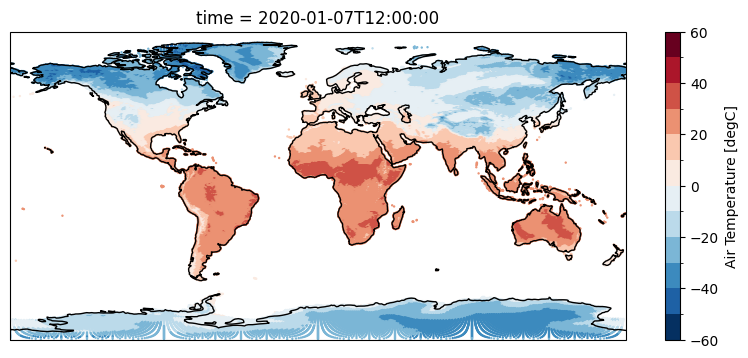

In [3]:
PROJ=ccrs.PlateCarree()
fig = plt.figure(figsize=(10,4),)
ax1 = plt.subplot(111, projection=PROJ)
ax1.coastlines()

# select a single time for T2m and convert to degC from K, then produce a scatter plot
(ds_ailand.sel(time="2020-01-07 12:00") - 273.15).plot.scatter(x="lon", y="lat", hue="t2m", 
                                         add_colorbar=True, hue_style="continuous", 
                                         edgecolor=None, 
                                         s=0.5,
                                         levels=12,
                                         cbar_kwargs={"label": "Air Temperature [degC]"},
                                         ax=ax1
                                        )

As well as continuous model output features our database also contains a lot of categorical climatological features which are time invariant. We can plot two examples of these below in the Vegetation Type and the Soil Type. There type of features will allow a ML model to learn how the model state should be updated for the given land surface characteristics

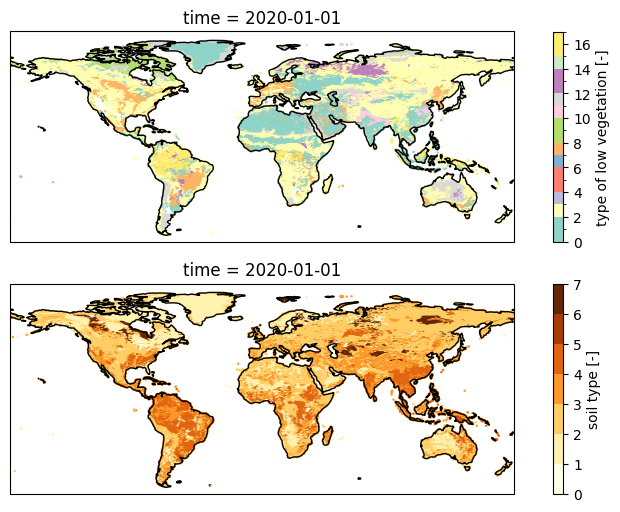

In [4]:
PROJ=ccrs.PlateCarree()
fig = plt.figure(figsize=(10,6),)
ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_extent((-180, 180, -60, 90), crs=PROJ)
ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_extent((-180, 180, -60, 90), crs=PROJ)

ds_ailand.isel(time=0).plot.scatter(x="lon", y="lat", hue="clim_tvl", 
                                    add_colorbar=True, hue_style="discrete", 
                                    cmap="Set3",
                                    edgecolor=None, 
                                    s=0.5,
                                    levels=19,
                                    ax=ax1
                                )

ds_ailand.isel(time=0).plot.scatter(x="lon", y="lat", hue="clim_sotype", 
                                    add_colorbar=True, hue_style="discrete", 
                                    cmap="YlOrBr",
                                    edgecolor=None, 
                                    s=0.5,
                                    levels=8,
                                    ax=ax2
                                )

Along with maps we can also inspact time-series of the dataset, below we select a single point and plot Level 3 Soil Moisture for all times for this gridcell

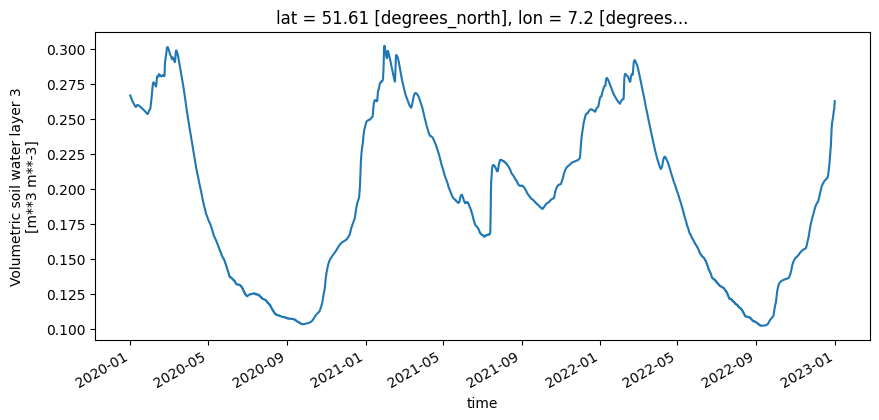

In [5]:
# Find nearest index for desired lat/lon
idx = find_nearest_idx(ds_ailand.lat, ds_ailand.lon, 51.5, 7.3).values
# Select the spatial index for this point and plot swvl3
ds_ailand.isel(x=idx).swvl3.plot(figsize=(10,4))

Selecting a subregion of the data is also straightforward

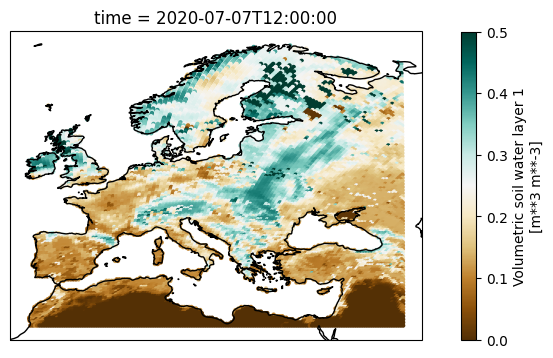

In [6]:
PROJ=ccrs.PlateCarree()
fig = plt.figure(figsize=(10,4),)
ax1 = plt.subplot(111, projection=PROJ)
ax1.coastlines()

# select a single time for T2m and convert to degC from K, then produce a scatter plot
(ds_ailand.where((ds_ailand.lat > 30) & (ds_ailand.lat < 75) & (ds_ailand.lon > -12) & (ds_ailand.lon < 45), drop=True)
          .sel(time="2020-07-07 12:00")
          .plot.scatter(x="lon", y="lat", hue="swvl1", 
                        add_colorbar=True,
                        edgecolor=None, 
                        cmap="BrBG",
                        s=5,
                        #levels=15,
                        vmin=0, vmax=0.5,
                        cbar_kwargs={"extend": "neither"},
                        ax=ax1
                        )
        )

We can also stack the dataset and convert to an array (selecting a subset of features), this can be useful when performing the ML training as we often need to reorganise the dimensions/shape of the data for any given training strategy

In [7]:
#Define a list of desired features from the dataset

feat_lst = [
            'clim_CLAKE',
            'clim_Ctype',
            'clim_cu',
            'clim_cvh',
            'clim_cvl',
            'clim_geopot',
            'clim_sdfor',
            'clim_sdor',
            'clim_sotype',
            'clim_tvh',
            'clim_tvl',
            'clim_z0m',
            'lai_hv', 
            'lai_lv', 
            'met_ctpf',
            'met_lwdown',
            'met_psurf',
            'met_qair',
            'met_rainf',
            'met_swdown',
            'met_snowf',
            'met_tair',
            'met_wind_e',
            'met_wind_n',
            'swvl1',
            'swvl2',
            'swvl3',
            'stl1',
            'stl2',
            'stl3',
            'snowc',
           ]

# Select features and time subset, convert to an array and stack the space+time dimensions to get a 2D array 
# We then transpose this array so that each row now provides a single sample to train on
ds_features = (ds_ailand[feat_lst].isel(time=slice(0, 24))
                .to_array()
                .stack(z=["time", "x"])
                .transpose()
                )
ds_features

<xarray.DataArray (z: 4489680, variable: 31)>
dask.array<transpose, shape=(4489680, 31), dtype=float32, chunksize=(1870700, 1), chunktype=numpy.ndarray>
Coordinates:
    lat       (z) float32 dask.array<chunksize=(4489680,), meta=np.ndarray>
    lon       (z) float32 dask.array<chunksize=(4489680,), meta=np.ndarray>
  * variable  (variable) object 'clim_CLAKE' 'clim_Ctype' ... 'stl3' 'snowc'
  * z         (z) object MultiIndex
  * time      (z) datetime64[ns] 2020-01-01 2020-01-01 ... 2020-01-06T18:00:00
  * x         (z) int32 2192 2193 2194 2195 2326 ... 654397 654398 654399 654400
Attributes:
    CONVERTED:     from grib files with grib_api
    GRID_POINTS:  gaussian grid 
    SOURCE:       ECMWF